<a href="https://colab.research.google.com/github/DiegoJohnson/AI/blob/master/Centernet_objects_as_points.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!/opt/bin/nvidia-smi

Tue Jan  7 02:53:19 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

CenterNet Paper : https://arxiv.org/pdf/1904.07850.pdf

Author repo : https://github.com/xingyizhou/CenterNet

Keras repo : https://github.com/see--/keras-centernet

# x,y,z + rotation vector

In [0]:
import numpy as np
import pandas as pd
import cv2
from tqdm import tqdm_notebook as tqdm
from glob import glob
import math
from math import floor, sin, cos, atan2, sqrt, log, exp, acos, pi
from cv2 import Rodrigues
from PIL import ImageFont, ImageDraw, Image, ImageEnhance, ImageOps
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
from inspect import signature
from multiprocessing import Pool

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, average_precision_score, precision_recall_curve

import keras
from keras.layers import Dense, Activation, Input, Conv2D, BatchNormalization, Add, UpSampling2D, ZeroPadding2D, Lambda
from keras.models import Sequential, Model
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import get_file
from tensorflow.contrib.opt import AdamWOptimizer
import keras.backend as K
import tensorflow as tf
import gc
import os
import torch

PATH = '/content/drive/My Drive/pku-autonomous-driving/'
os.listdir(PATH)

Using TensorFlow backend.


['car_models_json.zip',
 'sample_submission.csv',
 '.ipynb_checkpoints',
 'camera',
 'test',
 'train',
 'train.csv',
 'checkpoint.hdf5']

In [0]:
import warnings
warnings.filterwarnings("ignore")

In [0]:
train_all = pd.read_csv(PATH + 'train.csv')

train, validation = train_test_split(train_all, test_size=0.1, random_state=63)
train = train.reset_index(drop=True)
train.name = 'train'
validation = validation.reset_index(drop=True)
validation.name = 'validation'

test = pd.read_csv(PATH + 'sample_submission.csv')
test.name = 'test'

In [0]:
len(train)

3831

In [0]:
len(validation)

426

In [0]:
len(test)

2021

# I - Main

when weights=True, you will load the pretrained weights of HourglassNet

you can find it here: https://www.kaggle.com/diegojohnson/hourglassnet-weights

In [0]:
# def main():
#     # 1. set heads of HourglassNet
#     kwargs = {
#             'num_stacks': 2,
#             'cnv_dim': 256,
#             'inres': (512, 512),
#             }
#     heads = {
#             'car_pose': 6,
#             'confidence': 1
#             }
    
#     # 2. create model
#     model = HourglassNetwork(heads=heads, **kwargs, weights=True)
#     # model.load_weights('../input/centernet-objects-as-points/centernet_weights.hdf5', by_name=True)
    
#     # 3. train
#     train_model(model, epoch=3, batch_size=16)
    
#     # 4.predict
#     predict(model)

# II - Preprocessing


## 1. mutual conversion from strings to coordinates

In [0]:
def str_to_coords(s, names=['id', 'yaw', 'pitch', 'roll', 'x', 'y', 'z']):
    coords = []
    for l in np.array(s.split()).reshape([-1, 7]):
        coords.append(dict(zip(names, l.astype('float'))))
        if 'id' in coords[-1]:
            coords[-1]['id'] = int(coords[-1]['id'])
    return coords

def coords_to_str(coords):
    s = []
    for c in coords:
        # decode
        # c[0], c[1], c[2] = v2a(np.array([c[0], c[1], c[2]]))
        c[2] = rotate(c[2], -np.pi)

        c[3] *= 100
        c[4] *= 100
        c[5] = exp(-c[5])

        for n in range(7):
            s.append(str(c[n]))
    return ' '.join(s)

## 2. convert world coordinates to pixel coordinates

In [0]:
camera_matrix = np.array([[2304.5479, 0,  1686.2379],
                          [0, 2305.8757, 1354.9849],
                          [0, 0, 1]], dtype=np.float32)

def pixel_coords(s, img_h, img_w, names=['id', 'yaw', 'pitch', 'roll', 'x', 'y', 'z'], flip=False):
    coords = str_to_coords(s, names=names)
    xc = [c['x'] for c in coords]
    yc = [c['y'] for c in coords]
    zc = [c['z'] for c in coords]

    if flip:
        xc = [-x for x in xc]

    P = np.array(list(zip(xc, yc, zc))).T
    img_p = np.dot(camera_matrix, P).T
    img_p[:, 0] /= img_p[:, 2]
    img_p[:, 1] /= img_p[:, 2]
    u = img_p[:, 0]
    v = img_p[:, 1]
    zc = img_p[:, 2]

    # convert
    v -= 1500
    u += 356
    u = u * 128 / img_w
    v = v * 128 / img_h

    return u, v

## 3. Image preprocess
> Input of CenterNet: 512 x 512 x 3 (W, H, 3)

In [0]:
# def CreateMaskImages(imageName, clf='train'):

#     trainimage = cv2.imread(PATH  + clf +"_images/" + imageName + '.jpg')
#     imagemask = cv2.imread(PATH + clf + "_masks/" + imageName + ".jpg",0)
    
#     try:
#         imagemaskinv = cv2.bitwise_not(imagemask)
#         res = cv2.bitwise_and(trainimage,trainimage,mask = imagemaskinv)
#         return res
#     except:
#         return trainimage

In [0]:
def preprocess_image(img_name, clf='train'):
    img = cv2.imread(PATH  + clf +"/" + img_name + '.jpg')

    # vertical cutting
    img = img[1500: 2524]

    # horizontal expanding
    bg = np.ones_like(img) * img.mean(1, keepdims=True).astype(img.dtype)
    bg = bg[:, :356]
    img = np.concatenate([bg, img, bg], 1)

    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

    return img

## 5. Heatmap of center points: 128 x 128 x 1
> Output of CenterNet: (W/R, H/R, C) - here, R = 4, Classification C = 1. 
>
>(Center points with gaussian distributions is necessary to reduce the training loss when the model detect the points near the exact center.)

In [0]:
def heatmap(u, v, output_width=128, output_height=128, sigma=1):
    def get_heatmap(p_x, p_y):
        X1 = np.linspace(1, output_width, output_width)
        Y1 = np.linspace(1, output_height, output_height)
        [X, Y] = np.meshgrid(X1, Y1)
        X = X - floor(p_x)
        Y = Y - floor(p_y)
        D2 = X * X + Y * Y
        E2 = 2.0 * sigma ** 2
        Exponent = D2 / E2
        heatmap = np.exp(-Exponent)
        heatmap = heatmap[:, :, np.newaxis]
        return heatmap
    
    output = np.zeros((128,128,1))
    for i in range(len(u)):
        heatmap = get_heatmap(u[i], v[i])
        output[:,:] = np.maximum(output[:,:],heatmap[:,:])
      
    return output

## 6. Regression (yaw, pitch, roll, x, y, z) of the object pose: 128 x 128 x 6
Regressing rotation directly is not a good choice, I may try this way later.

https://www.kaggle.com/diegojohnson/a-way-to-regress-translation-and-rotation

The CenterNet paper use this method:

https://www.kaggle.com/diegojohnson/a-better-way-to-regress-yaw

In [0]:
# Euler Angles -> Rotation Matrix -> Rotation Vector
def a2v(yaw, pitch, roll):
    # Euler Angle -> Rotation Matrix
    # I think the pitch and yaw should be exchanged
    yaw, pitch = pitch, yaw
    Y = np.array([[cos(yaw), -sin(yaw), 0],
                  [sin(yaw), cos(yaw), 0],
                  [0, 0, 1]])
    P = np.array([[cos(pitch), 0, sin(pitch)],
                  [0, 1, 0],
                  [-sin(pitch), 0, cos(pitch)]])
    R = np.array([[1, 0, 0],
                  [0, cos(roll), -sin(roll)],
                  [0, sin(roll), cos(roll)]])
    rotation_m = np.dot(Y, np.dot(P, R))
    
    
    # Rotation Matrix -> Rotation Vector
    rotation_v = Rodrigues(rotation_m)[0]
    rotation_v = np.squeeze(rotation_v)
    
    return rotation_v

In [0]:
# Rotation Vector -> Rotation Matrix -> Euler Angles
def v2a(rotation_v):
    # Rotation Vector -> Rotation Matrix
    R = Rodrigues(rotation_v)[0]
    
    sq = sqrt(R[0,0] ** 2 +  R[1,0] ** 2)

    if  not (sq < 1e-6) :
        roll = atan2(R[2,1] , R[2,2])
        yaw = atan2(-R[2,0], sq)
        pitch = atan2(R[1,0], R[0,0])
    else :
        roll = atan2(-R[1,2], R[1,1])
        yaw = atan2(-R[2,0], sq)
        pitch = 0

    return yaw, pitch, roll

In [0]:
def rotate(x, angle):
    x = x + angle
    x = x - (x + np.pi) // (2 * np.pi) * 2 * np.pi
    return x

In [0]:
def pose(s, u, v, flip=False):
    regr = np.zeros([128, 128, 7], dtype='float32')
    coords = str_to_coords(s)

    # rotation vector
    for p_x, p_y, regr_dict in zip(u, v, coords):
        if p_x >= 0 and p_x < 128 and p_y >= 0 and p_y < 128:
            regr_dict.pop('id')

            if flip:
                for k in ['x', 'pitch', 'roll']:
                    regr_dict[k] = -regr_dict[k]

            # Euler angles
            # regr_dict['roll'] = rotate(regr_dict['roll'], np.pi)
            # v = a2v(regr_dict['yaw'], regr_dict['pitch'], regr_dict['roll'])
            # regr_dict['yaw'], regr_dict['pitch'], regr_dict['roll'] = v[0], v[1], v[2]
            regr_dict['roll'] = rotate(regr_dict['roll'], np.pi)
            regr_dict['pitch_sin'] = sin(regr_dict['pitch'])
            regr_dict['pitch_cos'] = cos(regr_dict['pitch'])

            # encode x,y,z
            regr_dict['x'] = regr_dict['x'] / 100
            regr_dict['y'] = regr_dict['y'] / 100
            regr_dict['z'] = - log(max(regr_dict['z'], 1e-15))
            
            regr[floor(p_y), floor(p_x)] = [regr_dict[n] for n in ['yaw', 'pitch_sin', 'pitch_cos', 'roll', 'x', 'y', 'z']]
   
    return regr

 ## Augmentation

In [0]:
def noise(image, prob=0.1):
    '''
    'AWN' donotes add white noise
    :param image: numpy.array, shape=[H,W,C]
    :param NS: noise strength (NS<=1)
    :return: numpy.array, shape=[H,W,C]
    '''
    random_prob = np.random.uniform()
    if random_prob > prob:
        return image
   
    NS = np.random.uniform(0, 0.2)
    image = np.array(image, dtype=np.float32)
    noise = np.random.randint(int(-255*NS), int(255*NS), size=image.shape)
    ny_image = np.add(image, noise)
    ny_image = (ny_image >= 255) * 255 +\
               (ny_image <= 0) * 0 +\
               ((ny_image > 0) & (ny_image < 255)) * ny_image
    return ny_image

def autocontrast(image, prob=0.5):
    random_prob = np.random.uniform()
    if random_prob > prob:
        return image
    image = Image.fromarray(image[..., ::-1], mode='RGB')
    image = ImageOps.autocontrast(image)
    image = np.array(image)[..., ::-1]
    return image


def equalize(image, prob=0.5):
    random_prob = np.random.uniform()
    if random_prob > prob:
        return image
    image = Image.fromarray(image[..., ::-1], mode='RGB')
    image = ImageOps.equalize(image)
    image = np.array(image)[..., ::-1]
    return image


def sharpness(image, prob=0.5, min=0, max=2, factor=None):
    random_prob = np.random.uniform()
    if random_prob > prob:
        return image
    if factor is None:
        factor = np.random.uniform(min, max)
    image = Image.fromarray(image[..., ::-1], mode='RGB')
    enhancer = ImageEnhance.Sharpness(image)
    image = enhancer.enhance(factor=factor)
    return np.array(image)[..., ::-1]


def color(image, prob=0.5, min=0., max=2., factor=None):
    random_prob = np.random.uniform()
    if random_prob > prob:
        return image
    if factor is None:
        factor = np.random.uniform(min, max)
    image = Image.fromarray(image[..., ::-1], mode='RGB')
    enhancer = ImageEnhance.Color(image)
    image = enhancer.enhance(factor=factor)
    return np.array(image)[..., ::-1]


def contrast(image, prob=0.5, min=0.3, max=1., factor=None):
    random_prob = np.random.uniform()
    if random_prob > prob:
        return image
    if factor is None:
        factor = np.random.uniform(min, max)
    image = Image.fromarray(image[..., ::-1], mode='RGB')
    enhancer = ImageEnhance.Contrast(image)
    image = enhancer.enhance(factor=factor)
    return np.array(image)[..., ::-1]


def brightness(image, prob=0.5, min=0.8, max=1., factor=None):
    random_prob = np.random.uniform()
    if random_prob > prob:
        return image
    if factor is None:
        factor = np.random.uniform(min, max)
    image = Image.fromarray(image[..., ::-1], mode='RGB')
    enhancer = ImageEnhance.Brightness(image)
    image = enhancer.enhance(factor=factor)
    return np.array(image)[..., ::-1]

# def flip(image, prob=0.5):
#             random_prob = np.random.uniform()
#             if random_prob > prob:
#                 return image
#             if factor is None:
#                 factor = np.random.uniform(min, max)
#             image = Image.fromarray(image[..., ::-1], mode='RGB')
#             enhancer = ImageEnhance.Contrast(image)
#             image = enhancer.enhance(factor=factor)
#             return np.array(image)[..., ::-1]

class VisualEffect:
    """
    Struct holding parameters and applying image color transformation.
    Args
        solarize_threshold:
        color_factor: A factor for adjusting color.
        contrast_factor: A factor for adjusting contrast.
        brightness_factor: A factor for adjusting brightness.
        sharpness_factor: A factor for adjusting sharpness.
    """

    def __init__(
            self,
            color_factor=None,
            contrast_factor=None,
            brightness_factor=None,
            sharpness_factor=None,
            color_prob=0.1,
            contrast_prob=0.1,
            brightness_prob=0.1,
            sharpness_prob=0.1,
            autocontrast_prob=0.1,
            equalize_prob=0.1

    ):
        self.color_factor = color_factor
        self.contrast_factor = contrast_factor
        self.brightness_factor = brightness_factor
        self.sharpness_factor = sharpness_factor
        self.color_prob = color_prob
        self.contrast_prob = contrast_prob
        self.brightness_prob = brightness_prob
        self.sharpness_prob = sharpness_prob
        self.autocontrast_prob = autocontrast_prob
        self.equalize_prob = equalize_prob

    def __call__(self, image):
        """
        Apply a visual effect on the image.
        Args
            image: Image to adjust
        """
        # id = np.random.randint(0, 8)
        id = 4
        # print(id)
        if id == 0:
            image = color(image, prob=self.color_prob, factor=self.color_factor)
        elif id == 1:
            image = contrast(image, prob=self.contrast_prob, factor=self.contrast_factor)
        elif id == 2:
            image = brightness(image, prob=self.brightness_prob, factor=self.brightness_factor)
        elif id == 3:
            image = sharpness(image, prob=self.sharpness_prob, factor=self.sharpness_factor)
        elif id == 4:
            pass
            # image = noise(image)
        elif id == 5:
            image = autocontrast(image, prob=self.autocontrast_prob)    
        else:
            image = equalize(image, prob=self.equalize_prob)
        # else:
        #     image = flip(image)

        return image

## 7. Example

### example()

In [0]:
def example(i):
    flip = np.random.randint(10) == 1

    fig, axes = plt.subplots(2, 4,figsize=(20,20))
    plt.subplots_adjust(top=0.5)

    img0 = preprocess_image(train['ImageId'][i])
    img = cv2.resize(img0, (512, 512))
    visual_effect = VisualEffect()
    img = visual_effect(img)
    if flip:
        img = img[:,::-1]
    axes[0, 0].set_title('Mask Image as Input')
    axes[0, 0].imshow(img)

    # Image height: img.shape[0] and v         Image width: img.shape[1] and u
    u, v = pixel_coords(train['PredictionString'][i], img0.shape[0], img0.shape[1], flip=flip)
    hm = np.squeeze(heatmap(u,v))
    axes[0, 1].set_title('Heatmap of Center Points as Output')
    axes[0, 1].imshow(hm)

    regr = pose(train['PredictionString'][i], u,v, flip=flip)
    axes[0, 2].set_title('Yaw - Ground Truth')
    axes[0, 2].imshow(regr[..., 0])

    axes[0, 3].set_title('Pitch - Ground Truth')
    axes[0, 3].imshow(regr[..., 1])

    axes[1, 0].set_title('Roll - Ground Truth')
    axes[1, 0].imshow(regr[..., 2])

    axes[1, 1].set_title('X - Ground Truth')
    axes[1, 1].imshow(regr[..., 3])

    axes[1, 2].set_title('Y - Ground Truth')
    axes[1, 2].imshow(regr[..., 4])

    axes[1, 3].set_title('Z - Ground Truth')
    axes[1, 3].imshow(regr[..., 5])

### visual_resize()

In [0]:
def visual_resize(i):
    fig, axes = plt.subplots(1,2,figsize=(20,20))
    img0 = preprocess_image(train['ImageId'][i])
    print(img0.shape[0], img0.shape[1])

    u, v = pixel_coords(train['PredictionString'][i], img0.shape[0], img0.shape[1])
    u *= 4
    v *= 4

    img = cv2.resize(img0, (512, 512))

    axes[1].imshow(img0)
    axes[0].imshow(img)
    print(img.shape[0], img.shape[1])
    
    axes[0].scatter(u, v, color='yellow', s=20)

### example()

1024 4096
512 512


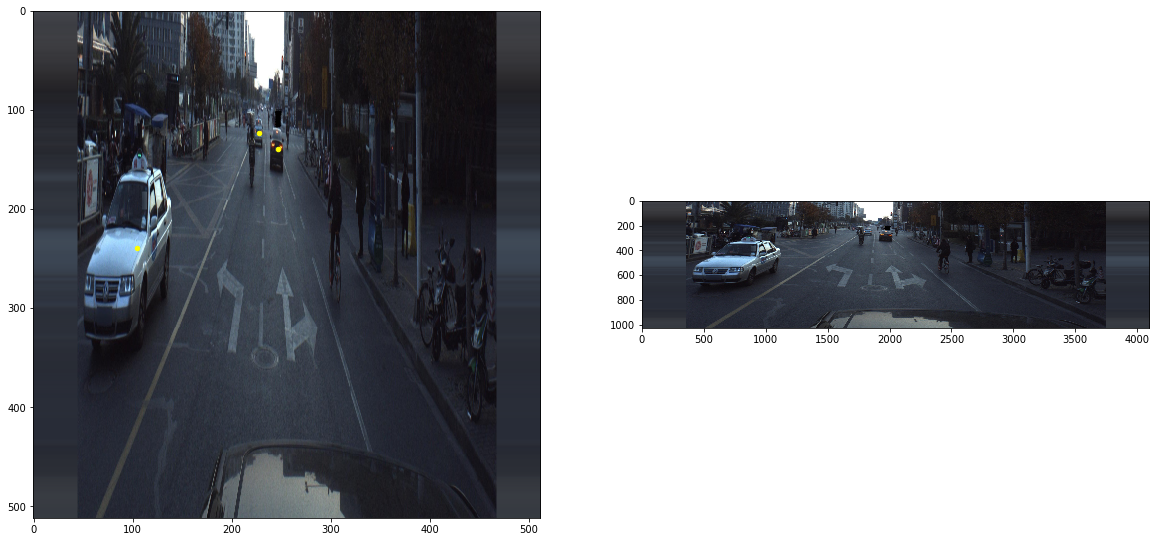

In [0]:
i = np.random.randint(0, len(train))
visual_resize(i)

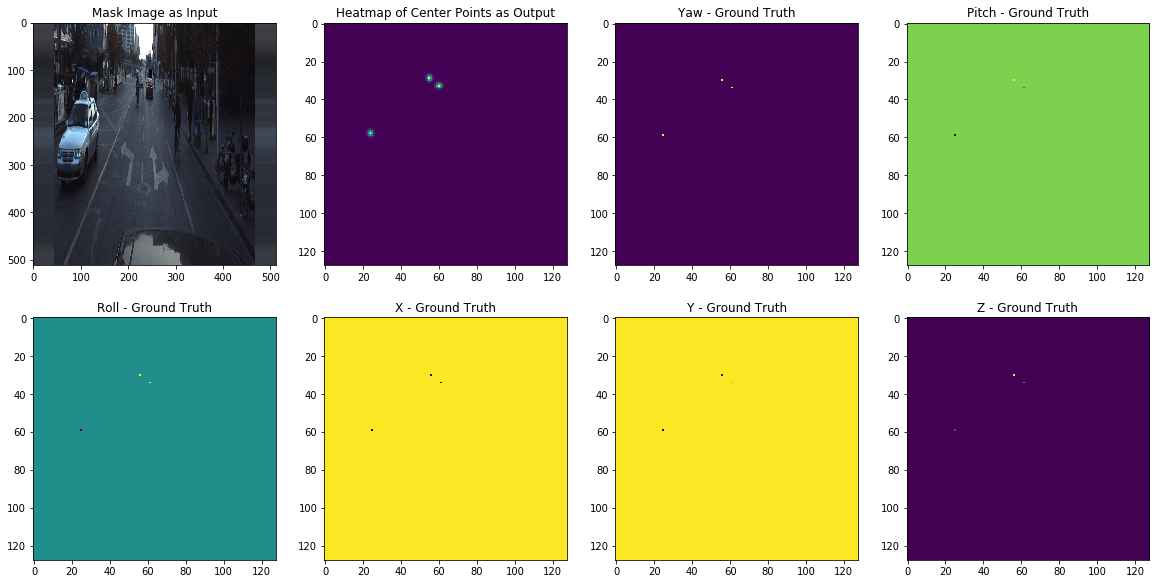

In [0]:
example(i)

## 6. Data Generator

In [0]:
def train_generator(train, batch_size=4):
    count=0
    X = []
    y1 = []
    y2 = []
    visual_effect = VisualEffect()

    while True:
        # random data
        flip = np.random.randint(10) == 1
        i = np.random.randint(0, len(train))

        img0 = preprocess_image(train['ImageId'][i])
        img = cv2.resize(img0, (512, 512))
        img = visual_effect(img)
        if flip:
            img = img[:,::-1]
        img = (img/255).astype('float32')
        X.append(img)
        
        u, v = pixel_coords(train['PredictionString'][i], img0.shape[0], img0.shape[1], flip=flip)
        hm = heatmap(u,v)
        y2.append(hm)

        p = pose(train['PredictionString'][i], u, v, flip=flip)
        y1.append(p)
        

        count+=1
        if count == batch_size:
            X_batch = np.array(X, dtype=np.float32)
            y1_batch = np.array(y1, dtype=np.float32)
            y2_batch = np.array(y2, dtype=np.float32)
            
            del X, y1, y2
            gc.collect()
            
            count = 0
            X = []
            y1 = []
            y2 = []
            
            yield(X_batch, {'confidence.1.1': y2_batch, 'location.1.1': y1_batch[:,:,:,4:], 'rotation.1.1': y1_batch[:,:,:, :4]})

In [0]:
def val_generator(val, batch_size=4):
    count=0
    X = []
    y1 = []
    y2 = []
    visual_effect = VisualEffect()

    while True:
        for i in range(len(val)):
            flip = np.random.randint(10) == 1

            img0 = preprocess_image(val['ImageId'][i])
            img = cv2.resize(img0, (512, 512))
            img = visual_effect(img)
            if flip:
                img = img[:,::-1]
            img = (img/255).astype('float32')
            X.append(img)
            
            u, v = pixel_coords(val['PredictionString'][i], img0.shape[0], img0.shape[1], flip=flip)
            hm = heatmap(u,v)
            y2.append(hm)

            p = pose(val['PredictionString'][i], u, v, flip=flip)
            y1.append(p)
            

            count+=1
            if count == batch_size:
                X_batch = np.array(X, dtype=np.float32)
                y1_batch = np.array(y1, dtype=np.float32)
                y2_batch = np.array(y2, dtype=np.float32)
                
                del X, y1, y2
                gc.collect()
                
                count = 0
                X = []
                y1 = []
                y2 = []
                
                yield(X_batch, {'confidence.1.1': y2_batch, 'location.1.1': y1_batch[:,:,:,4:], 'rotation.1.1': y1_batch[:,:,:, :4]})

# III - Model

## 1. backbone - HourglassNet

from https://blog.csdn.net/caikw62/article/details/95673125
![HourglassNet](https://img-blog.csdnimg.cn/20190716171510379.jpg?x-oss-process=image/watermark,type_ZmFuZ3poZW5naGVpdGk,shadow_10,text_aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L2NhaWt3NjI=,size_16,color_FFFFFF,t_70)

In [0]:
def HourglassNetwork(heads, num_stacks, cnv_dim=256, inres=(512, 512), weights=True,
                     dims=[256, 384, 384, 384, 512]):
    """Instantiates the Hourglass architecture.
    Optionally loads weights pre-trained on COCO.
    Note that the data format convention used by the model is
    the one specified in your Keras config at `~/.keras/keras.json`.
    # Arguments
      num_stacks: number of hourglass modules.
      cnv_dim: number of filters after the resolution is decreased.
      inres: network input shape, should be a multiple of 128.
      weights: one of `None` (random initialization),
            'ctdet_coco' (pre-training on COCO for 2D object detection),
            'hpdet_coco' (pre-training on COCO for human pose detection),
            or the path to the weights file to be loaded.
      dims: numbers of channels in the hourglass blocks.
    # Returns
      A Keras model instance.
    # Raises
      ValueError: in case of invalid argument for `weights`,
          or invalid input shape.
    """
    
    input_layer = Input(shape=(inres[0], inres[1], 3), name='HGInput')
    inter = pre(input_layer, cnv_dim)
    prev_inter = None
    outputs = []
    for i in range(num_stacks):
        prev_inter = inter
        _heads, inter = hourglass_module(heads, inter, cnv_dim, i, dims)
        if i == 1:
            outputs.extend(_heads)
        if i < num_stacks - 1:
            inter_ = Conv2D(cnv_dim, 1, use_bias=False, name='inter_.%d.0' % i)(prev_inter)
            inter_ = BatchNormalization(epsilon=1e-5, name='inter_.%d.1' % i)(inter_)

            cnv_ = Conv2D(cnv_dim, 1, use_bias=False, name='cnv_.%d.0' % i)(inter)
            cnv_ = BatchNormalization(epsilon=1e-5, name='cnv_.%d.1' % i)(cnv_)

            inter = Add(name='inters.%d.inters.add' % i)([inter_, cnv_])
            inter = Activation('relu', name='inters.%d.inters.relu' % i)(inter)
            inter = residual(inter, cnv_dim, 'inters.%d' % i)

    model = Model(inputs=input_layer, outputs=outputs)

    # load weights
    if weights:
        weights_path = get_file('HourglassNet.hdf5',
                          'https://github.com/see--/keras-centernet/releases/download/0.1.0/ctdet_coco_hg.hdf5',
                          cache_subdir='hourglassnet', 
                          file_hash='ce01e92f75b533e3ff8e396c76d55d97ff3ec27e99b1bdac1d7b0d6dcf5d90eb')
        model.load_weights(weights_path, by_name=True)

    return model

In [0]:
def hourglass_module(heads, bottom, cnv_dim, hgid, dims):
    # create left features , f1, f2, f4, f8, f16 and f32
    lfs = left_features(bottom, hgid, dims)

    # create right features, connect with left features
    rf1 = right_features(lfs, hgid, dims)
    rf1 = convolution(rf1, 3, cnv_dim, name='cnvs.%d' % hgid)

    # add 1x1 conv with two heads, inter is sent to next stage
    # head_parts is used for intermediate supervision
    heads = create_heads(heads, rf1, hgid)
    return heads, rf1

![convolution](https://img-blog.csdnimg.cn/20190716171120608.jpg?x-oss-process=image/watermark,type_ZmFuZ3poZW5naGVpdGk,shadow_10,text_aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L2NhaWt3NjI=,size_16,color_FFFFFF,t_70)

In [0]:
def convolution(_x, k, out_dim, name, stride=1):
    padding = (k - 1) // 2
    _x = ZeroPadding2D(padding=padding, name=name + '.pad')(_x)
    _x = Conv2D(out_dim, k, strides=stride, use_bias=False, name=name + '.conv')(_x)
    _x = BatchNormalization(epsilon=1e-5, name=name + '.bn')(_x)
    _x = Activation('relu', name=name + '.relu')(_x)
    return _x

![residual](https://img-blog.csdnimg.cn/20190716171157803.jpg?x-oss-process=image/watermark,type_ZmFuZ3poZW5naGVpdGk,shadow_10,text_aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L2NhaWt3NjI=,size_16,color_FFFFFF,t_70)

In [0]:
def residual(_x, out_dim, name, stride=1):
    shortcut = _x
    num_channels = K.int_shape(shortcut)[-1]
    _x = ZeroPadding2D(padding=1, name=name + '.pad1')(_x)
    _x = Conv2D(out_dim, 3, strides=stride, use_bias=False, name=name + '.conv1')(_x)
    _x = BatchNormalization(epsilon=1e-5, name=name + '.bn1')(_x)
    _x = Activation('relu', name=name + '.relu1')(_x)

    _x = Conv2D(out_dim, 3, padding='same', use_bias=False, name=name + '.conv2')(_x)
    _x = BatchNormalization(epsilon=1e-5, name=name + '.bn2')(_x)

    if num_channels != out_dim or stride != 1:
        shortcut = Conv2D(out_dim, 1, strides=stride, use_bias=False, name=name + '.shortcut.0')(
            shortcut)
        shortcut = BatchNormalization(epsilon=1e-5, name=name + '.shortcut.1')(shortcut)

    _x = Add(name=name + '.add')([_x, shortcut])
    _x = Activation('relu', name=name + '.relu')(_x)
    return _x

![pre](https://img-blog.csdnimg.cn/20190716170729501.jpg)

In [0]:
def pre(_x, num_channels):
    # front module, input to 1/4 resolution
    _x = convolution(_x, 7, 128, name='pre.0', stride=2)
    _x = residual(_x, num_channels, name='pre.1', stride=2)
    return _x

In [0]:
def left_features(bottom, hgid, dims):
    # create left half blocks for hourglass module
    # f1, f2, f4 , f8, f16, f32 : 1, 1/2, 1/4 1/8, 1/16, 1/32 resolution
    # 5 times reduce/increase: (256, 384, 384, 384, 512)
    features = [bottom]
    for kk, nh in enumerate(dims):
        pow_str = ''
        for _ in range(kk):
            pow_str += '.center'
        _x = residual(features[-1], nh, name='kps.%d%s.down.0' % (hgid, pow_str), stride=2)
        _x = residual(_x, nh, name='kps.%d%s.down.1' % (hgid, pow_str))
        features.append(_x)
    return features

In [0]:
def connect_left_right(left, right, num_channels, num_channels_next, name):
    # left: 2 residual modules
    left = residual(left, num_channels_next, name=name + 'skip.0')
    left = residual(left, num_channels_next, name=name + 'skip.1')

    # up: 2 times residual & nearest neighbour
    out = residual(right, num_channels, name=name + 'out.0')
    out = residual(out, num_channels_next, name=name + 'out.1')
    out = UpSampling2D(name=name + 'out.upsampleNN')(out)
    out = Add(name=name + 'out.add')([left, out])
    return out

In [0]:
def bottleneck_layer(_x, num_channels, hgid):
    # 4 residual blocks with 512 channels in the middle
    pow_str = 'center.' * 5
    _x = residual(_x, num_channels, name='kps.%d.%s0' % (hgid, pow_str))
    _x = residual(_x, num_channels, name='kps.%d.%s1' % (hgid, pow_str))
    _x = residual(_x, num_channels, name='kps.%d.%s2' % (hgid, pow_str))
    _x = residual(_x, num_channels, name='kps.%d.%s3' % (hgid, pow_str))
    return _x

In [0]:
def right_features(leftfeatures, hgid, dims):
    rf = bottleneck_layer(leftfeatures[-1], dims[-1], hgid)
    for kk in reversed(range(len(dims))):
        pow_str = ''
        for _ in range(kk):
            pow_str += 'center.'
        rf = connect_left_right(leftfeatures[kk], rf, dims[kk], dims[max(kk - 1, 0)], name='kps.%d.%s' % (hgid, pow_str))
    return rf

In [0]:
def create_heads(heads, rf1, hgid):
    _heads = []
    for head in sorted(heads):
        num_channels = heads[head]
        _x = Conv2D(256, 3, use_bias=True, padding='same', name=head + '.%d.0.conv' % hgid)(rf1)
        _x = Activation('relu', name=head + '.%d.0.relu' % hgid)(_x)
        if head == 'confidence':
            _x = Conv2D(num_channels, 1, activation='sigmoid', use_bias=True, name=head + '.%d.1' % hgid)(_x)
        else:
            _x = Conv2D(num_channels, 1, use_bias=True, name=head + '.%d.1' % hgid)(_x)
        _heads.append(_x)
    return _heads

## 2. Decode

In [0]:
# use maxpooling as nms
def _nms(heat, kernel=3):
    hmax = K.pool2d(heat, (kernel, kernel), padding='same', pool_mode='max')
    keep = K.cast(K.equal(hmax, heat), K.floatx())
    return heat * keep

In [0]:
def _ctdet_decode(hm, reg, k=100, output_stride=4):
    hm = _nms(hm)
    hm_shape = K.shape(hm)
    reg_shape = K.shape(reg)
    batch, width, cat = hm_shape[0], hm_shape[2], hm_shape[3]

    hm_flat = K.reshape(hm, (batch, -1))
    reg_flat = K.reshape(reg, (reg_shape[0], -1, reg_shape[-1]))
    
    def _process_sample(args):
        _hm, _reg = args
        _scores, _inds = tf.math.top_k(_hm, k=k, sorted=True)
        _inds = K.cast(_inds / cat, 'int32')
        _reg = K.gather(_reg, _inds)
        
        # get yaw, pitch, roll, x, y, z from regression
        yaw =  _reg[..., 0]
        pitch_sin =  _reg[..., 1]
        pitch_cos = _reg[..., 2]
        roll =  _reg[..., 3]
        x =  _reg[..., 4]
        y =  _reg[..., 5]
        z =  _reg[..., 6]

        _detection = K.stack([yaw, pitch_sin, pitch_cos, roll, x, y, z, _scores], -1)
        return _detection
    
    detections = K.map_fn(_process_sample, [hm_flat, reg_flat], dtype=K.floatx())
    return detections

In [0]:
def CtDetDecode(model, hm_index=0, location_index=1, pose_index=2, k=100, output_stride=4):
    def _decode(args):
        hm, location, pose = args
        reg = tf.concat([pose, location], axis=3)
        return _ctdet_decode(hm, reg, k=k, output_stride=output_stride)

    output = Lambda(_decode)([model.outputs[i] for i in [hm_index, location_index, pose_index]])
    model = Model(model.input, output)
    return model

## loss function

In [0]:
# 2. def focal_loss
    def focal_loss(hm_true, hm_pred):
        pos_mask = tf.cast(tf.equal(hm_true, 1), tf.float32)
        neg_mask = tf.cast(tf.less(hm_true, 1), tf.float32)
        neg_weights = tf.pow(1 - hm_true, 4)

        pos_loss = -tf.math.log(tf.clip_by_value(hm_pred, 1e-4, 1)) * tf.pow(1 - hm_pred, 2) * pos_mask
        neg_loss = -tf.math.log(tf.clip_by_value(1 - hm_pred, 1e-4, 1)) * tf.pow(hm_pred, 2) * neg_weights * neg_mask

        num_pos = tf.reduce_sum(pos_mask)
        pos_loss = tf.reduce_sum(pos_loss)
        neg_loss = tf.reduce_sum(neg_loss)

        cls_loss = tf.cond(tf.greater(num_pos, 0), lambda: (pos_loss + neg_loss) / num_pos, lambda: neg_loss)
        return cls_loss
    
    def l1_loss(y_true, y_pred):
        mask = tf.zeros_like(y_true, dtype=tf.float32)
        mask = tf.equal(y_true, mask)
        mask = tf.cast(mask, tf.float32)
        mask = tf.reduce_sum(mask, axis=-1)
        
        one = tf.ones_like(mask, dtype=tf.float32)
        zero = tf.zeros_like(mask, dtype=tf.float32)
        mask = tf.where(tf.equal(mask, 3.), x=zero, y=one)
        mask = tf.tile(tf.expand_dims(mask, axis=-1), (1, 1, 1, 3))
        
        total_loss = tf.reduce_sum(tf.abs(y_true - y_pred * mask))
        reg_loss = total_loss / (tf.reduce_sum(mask) + 1e-4)
        return reg_loss

    def l1_loss_r(y_true, y_pred):
        mask = tf.zeros_like(y_true, dtype=tf.float32)
        mask = tf.equal(y_true, mask)
        mask = tf.cast(mask, tf.float32)
        mask = tf.reduce_sum(mask, axis=-1)
        
        one = tf.ones_like(mask, dtype=tf.float32)
        zero = tf.zeros_like(mask, dtype=tf.float32)
        mask = tf.where(tf.equal(mask, 4.), x=zero, y=one)
        mask = tf.tile(tf.expand_dims(mask, axis=-1), (1, 1, 1, 4))
        
        total_loss = tf.reduce_sum(tf.abs(y_true - y_pred * mask))
        reg_loss = total_loss / (tf.reduce_sum(mask) + 1e-4)
        
        return reg_loss

## train_model()

## model

In [0]:
# 1. set heads of HourglassNet
kwargs = {
        'num_stacks': 2,
        'cnv_dim': 256,
        'inres': (512, 512),
        }
heads = {
        'location': 3,  # output[1]
        'rotation': 4,  # output[2]
        'confidence': 1 # output[0]
        }

# 2. create model
model = HourglassNetwork(heads=heads, **kwargs, weights=False)

model.load_weights('/content/drive/My Drive/pku-autonomous-driving/checkpoint.hdf5', by_name=True)













767025152/767024392 [==============================] - 80s 0us/step


In [0]:
# choose the layers you want to train, len(model.layers) == 638
# Trainable params: 91,183,879
n = 0
for layer in model.layers:
    layer.trainable = False
    n += 1
    if n == 500:
        break
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
HGInput (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
pre.0.pad (ZeroPadding2D)       (None, 518, 518, 3)  0           HGInput[0][0]                    
__________________________________________________________________________________________________
pre.0.conv (Conv2D)             (None, 256, 256, 128 18816       pre.0.pad[0][0]                  
__________________________________________________________________________________________________
pre.0.bn (BatchNormalization)   (None, 256, 256, 128 512         pre.0.conv[0][0]                 
____________________________________________________________________________________________

In [0]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler

In [0]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, verbose=1), 
    ModelCheckpoint('/content/drive/My Drive/pku-autonomous-driving/checkpoint.hdf5', monitor='val_loss', save_best_only=True, verbose=1)]

In [0]:
# 3. compile
batch_size = 8
lr = 1e-2
model.compile(optimizer = AdamWOptimizer(weight_decay=1e-4, learning_rate=lr),
                loss = {'confidence.1.1':focal_loss, 'location.1.1': l1_loss, 'rotation.1.1':l1_loss_r},
                loss_weights = [1, 1, 1])

# def step_decay(epoch):
#    initial_lrate = 1e-3
#    drop = 0.5
#    epochs_drop = 5.0
#    lrate = initial_lrate * math.pow(drop,  math.floor((1+epoch)/epochs_drop))
#    return lrate

    
# 4. fit
history = model.fit_generator(train_generator(train,batch_size=batch_size),
                              steps_per_epoch = len(train) // batch_size,
                              epochs = 10,
                              validation_data = train_generator(validation, batch_size=batch_size),
                              validation_steps = len(validation) // batch_size,
                              callbacks = callbacks
                              )


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/10
638/957 [===================>..........] - ETA: 14:58 - loss: 0.7158 - confidence.1.1_loss: 0.5089 - location.1.1_loss: 0.0767 - rotation.1.1_loss: 0.1303

In [0]:
# model.save('/content/checkpoint.hdf5')

In [0]:
# model.load_weights('/content/drive/My Drive/pku-autonomous-driving/checkpoint.hdf5')

In [0]:
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## predict_X

In [0]:
def predict_X(data, clf, batch_size=32):
    modelx = CtDetDecode(model)
    
    def pred(i, batch_size=32):
        X_batch = []
        for n in range(i*batch_size, i*batch_size+batch_size):
            if n > len(data)-1:
                break
                
            img0 = preprocess_image(data['ImageId'][n], clf=clf)
            img = cv2.resize(img0, (512, 512))
            img = (img/255).astype('float32')    
            X_batch.append(img.tolist())
        X_batch = np.asarray(X_batch)

        detections = modelx.predict(X_batch)

        for b in range(len(detections)):
            submission = []
            for d in detections[b]:
                yaw, pitch_sin, pitch_cos, roll, x, y, z, score = d
                if score < 0.25:
                    continue
                else:
                    pitch_sin = pitch_sin / np.sqrt(pitch_sin**2 + pitch_cos**2)
                    pitch_cos = pitch_cos / np.sqrt(pitch_sin**2 + pitch_cos**2)
                    pitch = np.arccos(pitch_cos) * np.sign(pitch_sin)
                    d = [yaw, pitch, roll, x, y, z, score]
                    submission.append(d)

            Prediction_string = coords_to_str(submission)
            data['PredictionString'][i*batch_size + b] = Prediction_string

    for i in tqdm(range(len(data)//batch_size)):
        pred(i, batch_size)
    
    other = len(data) - len(data)//batch_size * batch_size
    if other > 0:
        pred(len(data)//batch_size)
    
    if data.name == 'test':
        data.to_csv('submission.csv', index=False)
    elif data.name == 'validation':
        data.to_csv('validation.csv', index=False)
    else:
        print('wrong')

## visual prediction

In [0]:
def pred(i, data, clf):
    modelx = CtDetDecode(model)
    
    img0 = preprocess_image(data['ImageId'][i], clf=clf)
    img = cv2.resize(img0, (512, 512))
    img = (img/255).astype('float32')
    X_batch = img[np.newaxis, :]

    detections = modelx.predict(X_batch)
    detections = np.squeeze(detections)

    submission = []
    for d in detections:
        yaw, pitch_sin, pitch_cos, roll, x, y, z, score = d
        if score < 0.25:
            continue
        else:
            pitch_sin = pitch_sin / np.sqrt(pitch_sin**2 + pitch_cos**2)
            pitch_cos = pitch_cos / np.sqrt(pitch_sin**2 + pitch_cos**2)
            pitch = np.arccos(pitch_cos) * np.sign(pitch_sin)
            d = [yaw, pitch, roll, x, y, z, score]
            submission.append(d)

    Prediction_string = coords_to_str(submission)
    data['PredictionString'][i] = Prediction_string

In [0]:
def predict_example(i):
    pred(i, test, clf = 'test')

    fig, axes = plt.subplots(1, 3,figsize=(20,20))
    plt.subplots_adjust(top=0.5)

    img0 = preprocess_image(test['ImageId'][i], clf='test')
    img = cv2.resize(img0, (512, 512))
    img = (img/255).astype('float32')
    axes[0].set_title('Input Image')
    axes[0].imshow(img)

    # Output Heatmap
    X_batch = img[np.newaxis, :]
    detections = model.predict(X_batch)
    axes[1].set_title('Output Heatmap')
    axes[1].imshow(np.squeeze(detections[0]))

    # Detection Result
    s = test['PredictionString'][i]
    u, v = pixel_coords(s, img0.shape[0], img0.shape[1], names=['yaw', 'pitch', 'roll', 'x', 'y', 'z', 'confidence'])
    hm = np.squeeze(heatmap(u,v))
    axes[2].set_title('Prediction Heatmap')
    axes[2].imshow(hm)

    output = np.array(s.split()).reshape([-1, 7])
    print(output)

## example

In [0]:
i = np.random.randint(0, len(test))
predict_example(i)

# validation and predict

In [0]:
print(len(validation))
validation.head()

In [0]:
# validation = train.sample(frac=0.05)
# validation = validation.reset_index(drop=True)
# validation.name = 'validation'

In [0]:
predict_X(validation, clf='train')

In [0]:
validation.tail()

In [0]:
def val_example(i):
    origin_s = validation['PredictionString'][i]
    print(np.array(origin_s.split()).reshape([-1, 7]))
    pred(i, validation, clf = 'train')

    fig, axes = plt.subplots(1, 3,figsize=(20,20))
    plt.subplots_adjust(top=0.5)

    img0 = preprocess_image(validation['ImageId'][i], clf='train')
    img = cv2.resize(img0, (512, 512))
    img = (img/255).astype('float32')
    axes[0].set_title('Input Image')
    axes[0].imshow(img)

    # Output Heatmap
    X_batch = img[np.newaxis, :]
    detections = model.predict(X_batch)
    axes[1].set_title('Output Heatmap')
    axes[1].imshow(np.squeeze(detections[0]))

    # Detection Result
    s = validation['PredictionString'][i]
    u, v = pixel_coords(s, img0.shape[0], img0.shape[1], names=['yaw', 'pitch', 'roll', 'x', 'y', 'z', 'confidence'])
    hm = np.squeeze(heatmap(u,v))
    axes[2].set_title('Prediction Heatmap')
    axes[2].imshow(hm)

    output = np.array(s.split()).reshape([-1, 7])
    print(output)

In [0]:
i = np.random.randint(0, len(validation))
val_example(i)

In [0]:
predict_X(test, clf='test')

In [0]:
!mkdir -p ~/.kaggle
!echo '{"username":"diegojohnson","key":"e32bd83644befce9f6be49197585bf3c"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions submit -c pku-autonomous-driving -f /content/submission.csv -m "HG"

## compute mAP

### functions

In [0]:
def expand_df(df, PredictionStringCols):
    df = df.dropna().copy()
    df['NumCars'] = [int((x.count(' ')+1)/7) for x in df['PredictionString']]

    image_id_expanded = [item for item, count in zip(df['ImageId'], df['NumCars']) for i in range(count)]
    prediction_strings_expanded = df['PredictionString'].str.split(' ',expand = True).values.reshape(-1,7).astype(float)
    prediction_strings_expanded = prediction_strings_expanded[~np.isnan(prediction_strings_expanded).all(axis=1)]
    df = pd.DataFrame(
        {
            'ImageId': image_id_expanded,
            PredictionStringCols[0]:prediction_strings_expanded[:,0],
            PredictionStringCols[1]:prediction_strings_expanded[:,1],
            PredictionStringCols[2]:prediction_strings_expanded[:,2],
            PredictionStringCols[3]:prediction_strings_expanded[:,3],
            PredictionStringCols[4]:prediction_strings_expanded[:,4],
            PredictionStringCols[5]:prediction_strings_expanded[:,5],
            PredictionStringCols[6]:prediction_strings_expanded[:,6]
        })
    return df

def str2coords(s, names):
    coords = []
    for l in np.array(s.split()).reshape([-1, 7]):
        coords.append(dict(zip(names, l.astype('float'))))
    return coords

def TranslationDistance(p,g, abs_dist = False):
    dx = p['x'] - g['x']
    dy = p['y'] - g['y']
    dz = p['z'] - g['z']
    diff0 = (g['x']**2 + g['y']**2 + g['z']**2)**0.5
    diff1 = (dx**2 + dy**2 + dz**2)**0.5
    if abs_dist:
        diff = diff1
    else:
        diff = diff1/diff0
    return diff

def RotationDistance(p, g):
    true=[ g['pitch'] ,g['yaw'] ,g['roll'] ]
    pred=[ p['pitch'] ,p['yaw'] ,p['roll'] ]
    q1 = R.from_euler('xyz', true)
    q2 = R.from_euler('xyz', pred)
    diff = R.inv(q2) * q1
    W = np.clip(diff.as_quat()[-1], -1., 1.)
    
    # in the official metrics code:
    # https://www.kaggle.com/c/pku-autonomous-driving/overview/evaluation
    #   return Object3D.RadianToDegree( Math.Acos(diff.W) )
    # this code treat θ and θ+2π differntly.
    # So this should be fixed as follows.
    W = (acos(W)*360)/pi
    if W > 180:
        W = 360 - W
    return W

def print_pr_curve(result_flg, scores, recall_total=1):
    average_precision = average_precision_score(result_flg, scores)
    precision, recall, _ = precision_recall_curve(result_flg, scores)
    recall *= recall_total
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.show()

thres_tr_list = [0.1, 0.09, 0.08, 0.07, 0.06, 0.05, 0.04, 0.03, 0.02, 0.01]
thres_ro_list = [50, 45, 40, 35, 30, 25, 20, 15, 10, 5]

def check_match(idx):
    keep_gt=False
    thre_tr_dist = thres_tr_list[idx]
    thre_ro_dist = thres_ro_list[idx]
    train_dict = {imgID:str2coords(s, names=['carid_or_score', 'pitch', 'yaw', 'roll', 'x', 'y', 'z']) for imgID,s in zip(train_df['ImageId'],train_df['PredictionString'])}
    valid_dict = {imgID:str2coords(s, names=['pitch', 'yaw', 'roll', 'x', 'y', 'z', 'carid_or_score']) for imgID,s in zip(valid_df['ImageId'],valid_df['PredictionString'])}
    result_flg = [] # 1 for TP, 0 for FP
    scores = []
    MAX_VAL = 10**10
    for img_id in valid_dict:
        for pcar in sorted(valid_dict[img_id], key=lambda x: -x['carid_or_score']):
            # find nearest GT
            min_tr_dist = MAX_VAL
            min_idx = -1
            for idx, gcar in enumerate(train_dict[img_id]):
                tr_dist = TranslationDistance(pcar,gcar)
                if tr_dist < min_tr_dist:
                    min_tr_dist = tr_dist
                    min_ro_dist = RotationDistance(pcar,gcar)
                    min_idx = idx
                    
            # set the result
            if min_tr_dist < thre_tr_dist and min_ro_dist < thre_ro_dist:
                if not keep_gt:
                    train_dict[img_id].pop(min_idx)
                result_flg.append(1)
            else:
                result_flg.append(0)
            scores.append(pcar['carid_or_score'])
    
    return result_flg, scores

### main

In [0]:
valid_df = pd.read_csv('/content/validation.csv')
expanded_valid_df = expand_df(valid_df, ['pitch','yaw','roll','x','y','z','Score'])
valid_df = valid_df.fillna('')

train_df = pd.read_csv('/content/drive/My Drive/pku-autonomous-driving/train.csv')
train_df = train_df[train_df.ImageId.isin(valid_df.ImageId.unique())]
# data description page says, The pose information is formatted as
# model type, yaw, pitch, roll, x, y, z
# but it doesn't, and it should be
# model type, pitch, yaw, roll, x, y, z
expanded_train_df = expand_df(train_df, ['model_type','pitch','yaw','roll','x','y','z'])

max_workers = 10
n_gt = len(expanded_train_df)
ap_list = []
p = Pool(processes=max_workers)
for result_flg, scores in p.imap(check_match, range(10)):
    if np.sum(result_flg) > 0:
        n_tp = np.sum(result_flg)
        recall = n_tp/n_gt
        ap = average_precision_score(result_flg, scores)*recall
        print_pr_curve(result_flg, scores, recall)
    else:
        ap = 0
    ap_list.append(ap)
map = np.mean(ap_list)
print('map:', map)

## train mAP - LB score

0.3: 0.08 - 0.015

0.25: 0.0974 - 0.015 